## **Blood donation prediction**

Due to an illness or injury, our body misses one or several components that make up healthy blood, and blood transfusion helps supply what our body is missing. About 5 million Americans need blood transfusion every year, reports <a href="https://www.webmd.com/a-to-z-guides/blood-transfusion-what-to-know#1">WebMD</a>.

<p>This is a dataset from blood donation drive in Taiwan, where mobile blood donation vehicles drive to universities and collect blood. We want to forecast if a donor will donate blood the next time the vehicle comes to a campus.</p>

First, let's start by loading the libraries required for this project.

In [1]:
# Import libraries
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import set_option
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

## Load in the dataset

In [2]:
# Read in dataset
df = pd.read_csv('dataset/transfusion.data')

# Display the first and last 5 rows of our dataset
display(df.head())
display(df.tail())

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
743,23,2,500,38,0
744,21,2,500,52,0
745,23,3,750,62,0
746,39,1,250,39,0
747,72,1,250,72,0


## Let's rename the class column first

In [3]:
df.rename(columns={'whether he/she donated blood in March 2007': 'Target'}, inplace=True)

## Let's take a closer look at our loaded data

In [4]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Recency (months)       748 non-null    int64
 1   Frequency (times)      748 non-null    int64
 2   Monetary (c.c. blood)  748 non-null    int64
 3   Time (months)          748 non-null    int64
 4   Target                 748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


We have 748 instances to work with and no missing values. We can also confirm the data has 5 attributes, including the class attribute.

## Take a look at the data types of each attribute

In [5]:
# Datatypes
df.dtypes

Recency (months)         int64
Frequency (times)        int64
Monetary (c.c. blood)    int64
Time (months)            int64
Target                   int64
dtype: object

We can see that all the attributes are numeric (int), including the class value.

## Summarize the distribution of each attribute

In [6]:
# Descriptions, change precision to 3 places
set_option('precision', 3)
df.describe()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),Target
count,748.000,748.000,748.000,748.000,748.000
mean,9.507,5.515,1378.676,34.282,0.238
std,8.095,5.839,1459.827,24.377,0.426
min,0.000,1.000,250.000,2.000,0.000
25%,2.750,2.000,500.000,16.000,0.000
50%,7.000,4.000,1000.000,28.000,0.000
75%,14.000,7.000,1750.000,50.000,0.000
max,74.000,50.000,12500.000,98.000,1.000


The data has the same range, but interestingly different mean values. There may be some benefits from standardizing the data, especially the 'monetary' column.

## Take a quick look at the breakdown of class values

In [7]:
# Class distribution
df['Target'].value_counts()

0    570
1    178
Name: Target, dtype: int64

We can see that the classes are not that balanced between 0 (not donated) and 1 (donated).

## Let's visualize individual attributes

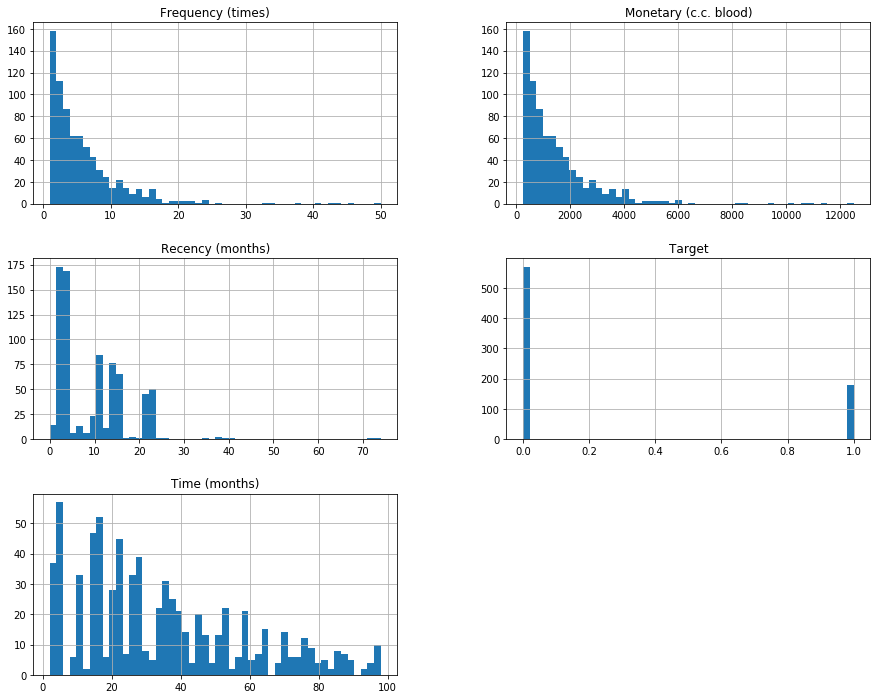

In [8]:
# Histograms
df.hist(bins=50, figsize=(15,12));

We can see that there are exponential decay-like distributions for most of the attributes.

## Same perspective of the data using density plots

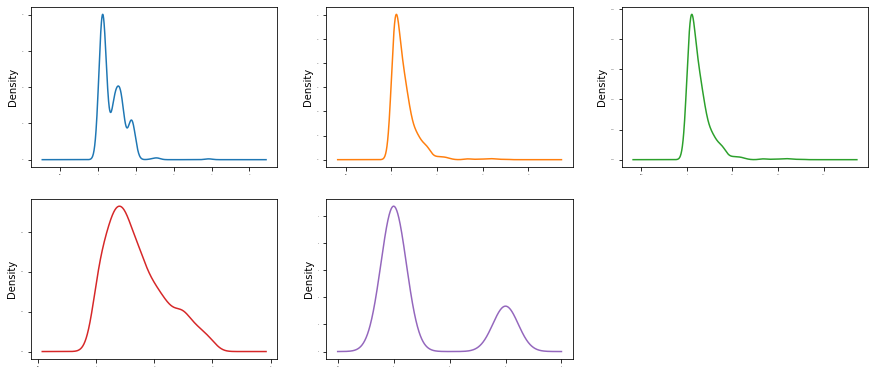

In [9]:
# Density plots
df.plot(kind='density', subplots=True, figsize=(15,10), layout=(3,3), sharex=False, legend=False, fontsize=1);

Most of the attributes have a skewed distribution. A power transform like a Box-Cox transform that can correct for the skew in distributions might be useful.

## Box and whisker plots to get an idea of the spread of values

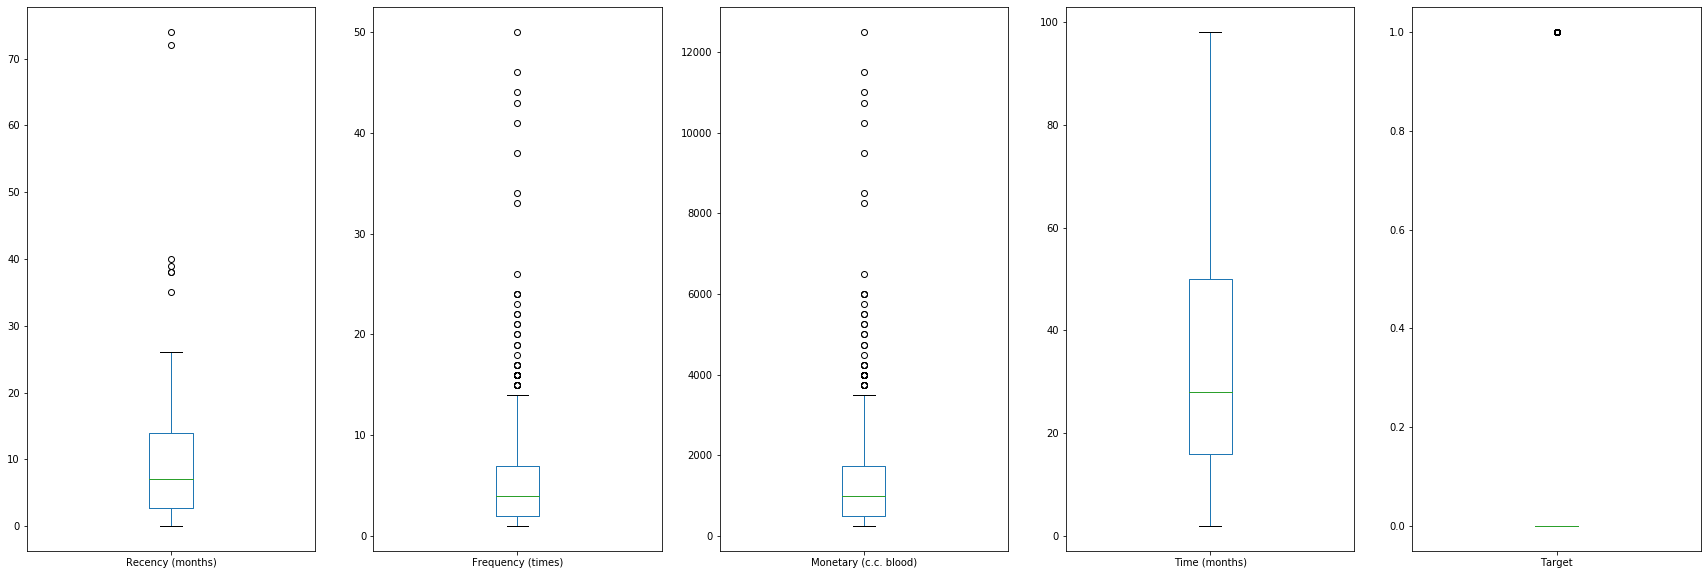

In [10]:
# Box and whisker plots
df.plot(kind='box', subplots=True)
plt.gcf().set_size_inches(30,10);

We can see that the attributes have quite same spreads, except one. Maybe we need to standardize the data for modeling to get all the means lined up.

## Let's split out validation dataset

In [11]:
# Split out validation dataset
X = df.drop('Target', axis=1)
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

## Take a look at the variance of the dataset

In [12]:
# X_train's variance, rounding the output to 3 decimal places
X_train.var()

Recency (months)         6.693e+01
Frequency (times)        3.383e+01
Monetary (c.c. blood)    2.114e+06
Time (months)            6.111e+02
dtype: float64

Monetary (c.c. blood)'s variance is very high, which may get more weight by the model than any other feature. Let's log normalize to correct the high variance.

## Normalize the high-variance attribute

In [13]:
# Copy X_train and X_test into X_train_normed and X_test_normed
X_train_normed, X_test_normed = X_train.copy(), X_test.copy()

# Specify which column to normalize
col_to_normalize = 'Monetary (c.c. blood)'

# Log normalization
for df_ in [X_train_normed, X_test_normed]:
    # Add log normalized column
    df_['monetary_log'] = np.log(df_[col_to_normalize])
    # Drop the original column
    df_.drop(columns=col_to_normalize, inplace=True)

# Check the variance for X_train_normed
X_train_normed.var().round(3)

Recency (months)      66.929
Frequency (times)     33.830
Time (months)        611.147
monetary_log           0.837
dtype: float64

In [14]:
# Define a list called classifier that contains the tuples (classifier name, classifier)
classifiers = [('logreg', LogisticRegression()),
('knn', KNN()),
('rf', RandomForestClassifier()),
('naive', GaussianNB()),
('svm', SVC())]

## Evaluate algorithms: baseline

The algorithms all use default tuning parameters. We will display the mean and standard deviation of accuracy for each algorithm as we calculate it and collect the results for use later.

In [15]:
results = []
names = []
for name, model in classifiers:
    kfold = KFold(n_splits=10)
    cv_score = cross_val_score(model, X_train_normed, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_score)
    names.append(name)
    print(f'{name}: {cv_score.mean()}, {cv_score.std()}')

logreg: 0.7880012531328321, 0.0507184227882044
knn: 0.7504385964912281, 0.0329532240518048
rf: 0.7343358395989974, 0.06724666203287044
naive: 0.7612781954887219, 0.05857156128431883
svm: 0.7594611528822055, 0.043187837281021664


The results suggest that Logistic Regression is way ahead of other classifiers.

## Let's compare the algorithms

These are just mean accuracy values. Let's take a look at the distribution of accuracy values across different cross-validation folds, using box and whisker plots.

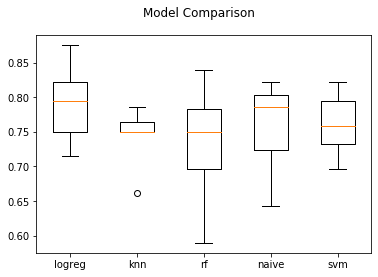

In [16]:
fig = plt.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

The results show a tight distribution for Logistic Regression, suggesting low variance. The same for SVM but with poor results which is little surprising.

## Tuning Logistic Regression

We can tune one key parameter of the Logistic Regression algorithm, the value of C (how much to relax the
margin). The default is to use the L2 (Ridge) penalty with a C value set to 1.0. We will perform a grid
search using 10-fold cross validation with the normalized training dataset. We will
try a number of C values with less bias and more bias (less than and more than 1.0 respectively).

In [17]:
# Tune scaled logistic regression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
kfold = KFold(n_splits=10)
model = LogisticRegression()
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring = 'accuracy', cv=kfold)
grid_result = grid.fit(X_train_normed, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.793358 using {'C': 0.1}
0.773716 (0.035856) with: {'C': 0.001}
0.775501 (0.040940) with: {'C': 0.01}
0.793358 (0.045176) with: {'C': 0.1}
0.788001 (0.050718) with: {'C': 1}
0.788001 (0.050718) with: {'C': 10}
0.789787 (0.048351) with: {'C': 100}
0.789787 (0.048351) with: {'C': 1000}


We can see the most accurate configuration was Logistic Regression with a C value of 0.1. The accuracy 79.33% is seemingly better than the tuning.

## Finalize the model

Logistic Regression showed the most promise as a low complexity and stable model for this problem. Now we will finalize the model by training it on the entire training dataset and make predictions for the hold-out validation dataset to confirm our findings.

In [18]:
# Find the best paramaters
grid.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
# Estimate accuracy on validation dataset
model = LogisticRegression(C=0.1)
model.fit(X_train_normed, y_train)
y_pred = model.predict(X_test_normed)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.7914438502673797
[[140   3]
 [ 36   8]]


We can see that we have achieved an accuracy of 79% on the held-out validation dataset. This score matches very closely to our expectations estimated above during the tuning of logistic regression.

## Write out pickel model

In [20]:
joblib.dump(grid.best_estimator_, '../Pickle/blood_logreg.pkl')

['../Pickle/blood_logreg.pkl']